# Content

Time series clustering using K means with Euclidean and DTW distance

In [ ]:
%matplotlib inline
from tslearn.clustering import silhouette_score

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import matplotlib
import json


# Preparing the data

In [ ]:
data = pd.read_csv('./data/data_long.csv')

def listify(row):
    row = str(row).replace('[', '').replace(']', '').split(',')
    row = [float(y) for y in row]

    return np.asarray(row)

data.loc[:, 'points'] = data.loc[:, 'points'].apply(listify)
points = data['points']

In [ ]:

points = np.array(points.values.tolist())
points.resize(points.shape[0], 900, 1)
print(points.shape)

In [ ]:
seed = 10
np.random.seed(seed)
X_train = points
sz = X_train.shape[1]

In [ ]:

print(np.mean(X_train[1,:]))
print(np.std(X_train[1,:]))

#### Looking at some of the patterns

In [ ]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)

## Training the model and saving the results (saved in /analysis/plots/cluster/).
  * Using Euclidean distance

In [ ]:
X_train.var()

In [26]:
# Euclidean k-means

seed = 10
np.random.seed(seed)


n_clusterss = [12, 27]
silhouette_scores = []
wcss = []
cluster_labelss = []

cluster_types = {'decreasing': [8, 21, 17, 4, 15, 2, 12], 'increasing': [10, 13, 20, 14, 11, 25, 22, 7]}

# Compute the total variance
total_variance = X_train.var()

for n_clusters in n_clusterss:
    print("Euclidean k-means ---- {}".format(n_clusters))
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed, n_jobs=-1)
    cluster_labels = km.fit_predict(X_train)
    cluster_labelss.append(cluster_labels)

    wcscore = km.fit(X_train).inertia_
    print(wcscore)
    wcss.append(wcscore)

    s_score = silhouette_score(X_train, cluster_labels, metric="euclidean")
    print("Euclidean silhoutte: {:.2f}".format(s_score))
    silhouette_scores.append(s_score)

    # Calculate the percentage of variance explained
    percentage_variance_explained = (1 - wcscore / (len(data) * total_variance)) * 100
    print("Percentage of variance explained: {:.2f}%".format(percentage_variance_explained))

    if False:
        centers = []
        for i in range(0, n_clusters):
            centers.append(list(km.cluster_centers_[i].flatten()))

        import pickle
        with open('cluster_curves.pkl','wb') as f:
            pickle.dump(centers, f)

        pd.DataFrame(np.asarray(centers).transpose()).to_csv("./data/cluster_centers.csv")

        # Plot each average curve independently:
        for yi in range(n_clusters):
            if yi in cluster_types['decreasing']:
                color = "#a30202" # Red
            elif yi in cluster_types['increasing']:
                color = "#2fa302" # Green
            else:
                color = "#b37d00" # Orange

            color = "#b37d00" # Orange

            plt.plot(km.cluster_centers_[yi].ravel(), "r-", linewidth=40, color=color)
            plt.tight_layout()

            plt.xlim(0, sz)
            plt.ylim(0, 100)
            plt.axis('off')

            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(18.5, 18.5)

            plt.savefig("./plots/cluster/cluster_{}_{}.png".format(yi, n_clusters))
            plt.close()

        fig = plt.figure()
        for yi in range(n_clusters):
            ax = plt.subplot(4, 3, yi + 1)
            for xx in X_train[cluster_labels == yi]:
                plt.plot(xx.ravel(), "k-", alpha=.2)
            plt.plot(km.cluster_centers_[yi].ravel(), "r-")

            plt.xlim(0, sz)
            plt.ylim(0, 100)
            plt.text(0.37, 1.05,'Cluster %d' % (yi + 1),
                    transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

            print("Cluster {} done!".format(yi))

        data['cluster_labels'] = cluster_labels
        data.to_csv("./data/data_long_cluster_{}.csv".format(str(n_clusters)))
        plt.tight_layout(pad=1.2, h_pad=1.5)

        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(10, 20)
        
        fig.savefig("./plots/cluster/k_means_{}.png".format(str(n_clusters)), dpi=500)
        plt.close()

Euclidean k-means ---- 12
128179.19629568755
Euclidean silhoutte: 0.16
Percentage of variance explained: 88.90%
Euclidean k-means ---- 27
103702.69802725801
Euclidean silhoutte: 0.11
Percentage of variance explained: 91.02%


12


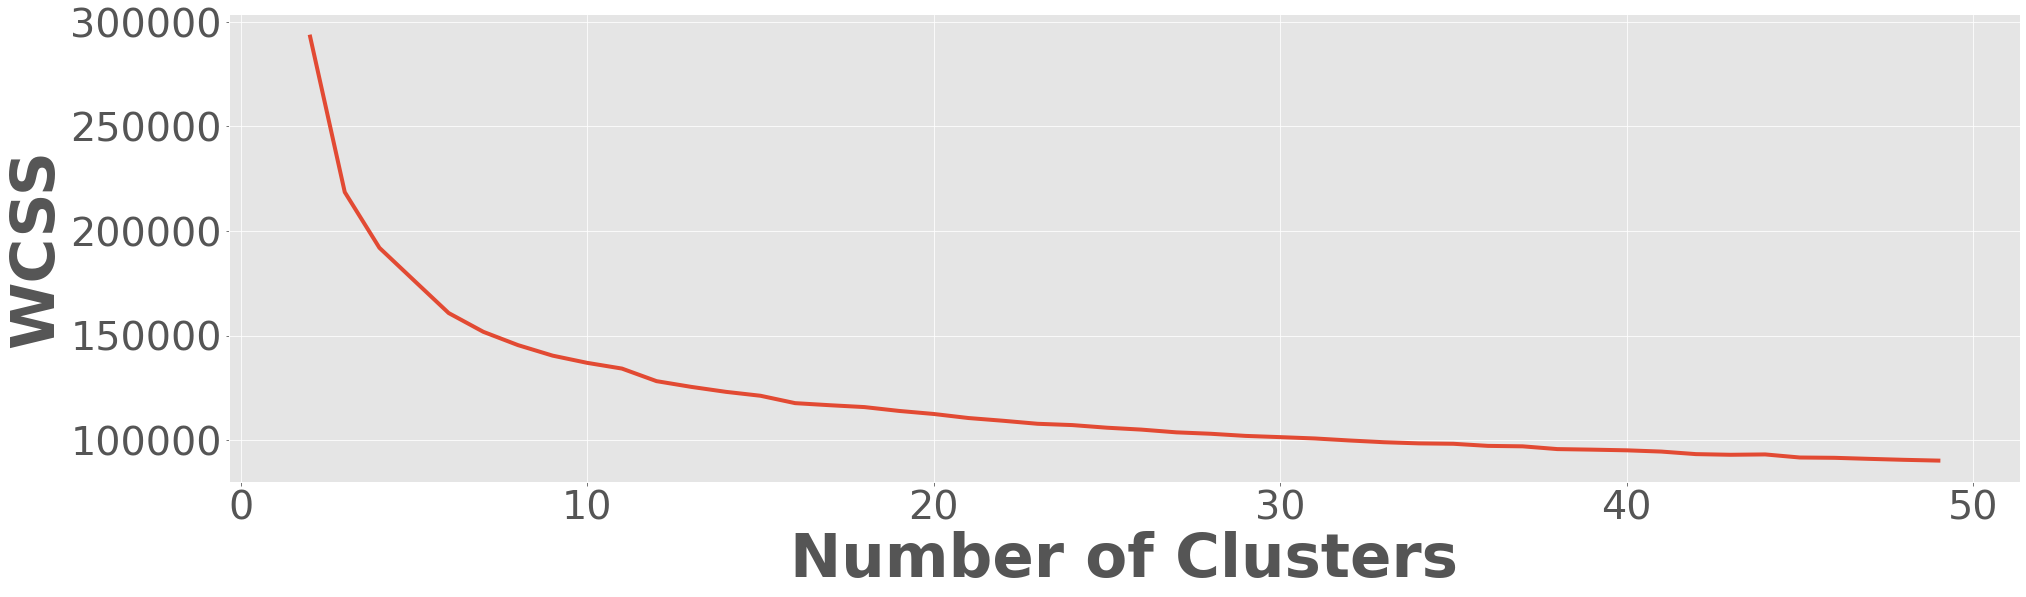

In [25]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def plot_error_line(n_clusterss, wcss):
    SMALL_SIZE = 26 * 1.7 * 9/10
    MEDIUM_SIZE = 40 * 1.7 * 9/10
    BIGGER_SIZE = 48 * 1.7 * 9/10

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE + 1)  # fontsize of the figure title
    plt.figure()

    plt.plot(n_clusterss, wcss, linewidth=4)
    plt.ylabel("WCSS", fontweight='bold')
    plt.xlabel("Number of Clusters", fontweight='bold')

    plt.tight_layout()


    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.gcf().set_size_inches(30, 10)
    plt.savefig("./plots/cluster_elbow.png", dpi=500)

from kneed import KneeLocator
kn = KneeLocator(n_clusterss, wcss, curve='convex', direction='decreasing')
print(kn.knee)

plot_error_line(n_clusterss, wcss)


In [ ]:
plt.plot(n_clusterss, silhouette_scores)